*How many qualitative and quantitative variables are there? What are appropiate visuals for quantitative vs qualitative data? What are appropiate measures for correlations when dealing with qualitative and quantitative variables?

What is the correlation between the variables and the price? Why do you think some variables are more correlated than others?

How are the variables themselves correlated to each other? Can you find groups of variables that are correlated together?*

In [9]:
#Import the clean data file
import pandas as pd
import numpy as np
import seaborn as sns

file_path = "cleaned_properties.csv"
with open(file_path, 'r', encoding='utf-8') as f:
    first_line = f.readline()
    sep = ';' if ';' in first_line else ','
df = pd.read_csv(file_path, sep=sep, low_memory=False)

In [10]:
#TO BE REMOVED LATER

# Defining mapping rules for each region

epc_mapping = {
    "Flanders": {
        "A+": "excellent",
        "A": "excellent",
        "B": "good",
        "C": "poor",
        "D": "poor",
        "E": "bad",
        "F": "bad"
    },
    
    "Brussels-Capital": {
        "A": "excellent",
        "B": "good",
        "C": "good",
        "D": "poor",
        "E": "poor",
        "F": "bad",
        "G": "bad"
    },
    
    "Wallonia": {
        "A++": "excellent",
        "A+": "excellent",
        "A": "good",
        "B": "good",
        "C": "poor",
        "D": "poor",
        "E": "poor",
        "F": "bad",
        "G": "bad"
    }
}

# Function that uses the rule on region

def recode_epc(row):
    region = row['region']
    epc = row['epc']

    if pd.isna(region) or pd.isna(epc):
        return np.nan
    
    region_rules = epc_mapping.get(region)

    if region_rules is None:
        return np.nan
    
    return region_rules.get(epc, np.nan)

df['epc_group'] = df.apply(recode_epc, axis =1)
df = df.drop(columns=['epc'])
df = df.rename(columns={'epc_group': 'epc'})
df['epc'].value_counts(dropna=False)


epc
NaN          24476
poor         19225
good         13752
bad          12046
excellent     6009
Name: count, dtype: int64

In [11]:
# Capping and log transformations

df_before = df.copy() #Keeping a copy of data before capping
cap_vars = ['price', 'surface_land_sqm', 'total_area_sqm','garden_sqm', 'terrace_sqm', 'nbr_bedrooms', 'nbr_frontages']
lower_cap = 0.01
upper_cap = 0.99
for var in cap_vars:
    lower = df[var].quantile(lower_cap)
    upper = df[var].quantile(upper_cap)
    df[var] = np.where(df[var] < lower, lower,
                       np.where(df[var] > upper, upper, df[var]))

# Initiating the log transfiormations (nbr_bedrooms and nbr_frontages were normalized only by the capping so no need for log-trandformation)
log_vars = ['price', 'surface_land_sqm', 'total_area_sqm','garden_sqm', 'terrace_sqm']
for var in log_vars:
    df[f'{var}_log'] = np.log1p(df[var])
df[[f'{v}_log' for v in log_vars]].skew()


price_log               0.633027
surface_land_sqm_log   -1.389089
total_area_sqm_log      0.359023
garden_sqm_log          1.949138
terrace_sqm_log         0.382170
dtype: float64

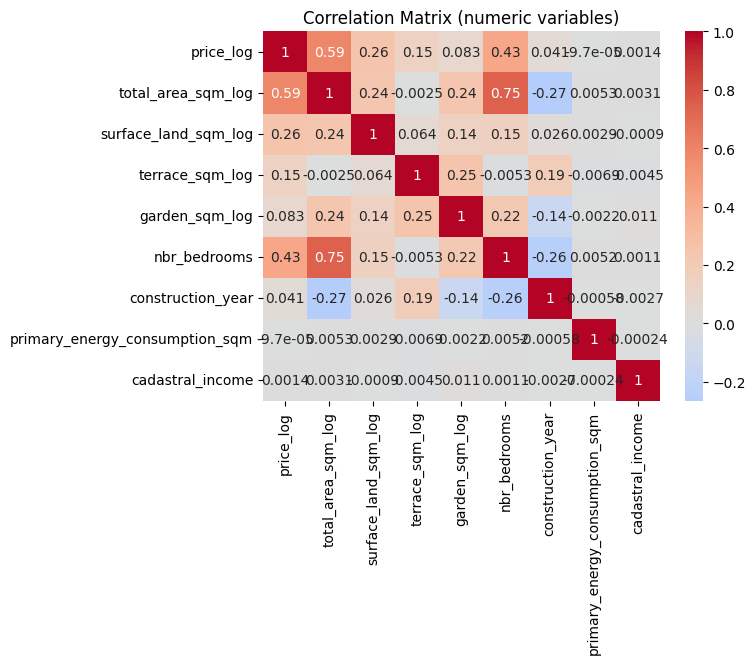

In [12]:
# Corr between price and continuous (numeric) variables (Correlation Matrix) - Pearson's corr
import matplotlib.pyplot as plt

#Numeric vars
num_cols = ['price_log', 'total_area_sqm_log', 'surface_land_sqm_log', 'terrace_sqm_log','garden_sqm_log', 'nbr_bedrooms', 'construction_year', 'primary_energy_consumption_sqm','cadastral_income']

corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix (numeric variables)")
plt.show()

In [19]:
# which regions/ provinces have the highest median prices

df.groupby('region')['price'].median().sort_values(ascending=False)

region
Brussels-Capital    3800000.0
Flanders            3511000.0
Wallonia            2700000.0
Name: price, dtype: float64

In [28]:
# Price_log vs Numeric/log-tranformed variables - Pearson's 
# Appraoch: for the moment Nans are ignored by pandas, however,to decide whether we will put median to missing values in numerical
'''
Interpretation
Pearson r:
0.0–0.3 -> weak correlation
0.3–0.6 -> moderate correlation
0.6–0.9 -> strong correlation
0.9+ -> very strong correlation
p-value:
Small p (<0.05) -> correlation is statistically significant
Large p (≥0.05) -> not significant; could be noise
'''
import pandas as pd
import numpy as np
from scipy.stats import pearsonr


num_cols = ['price_log', 'total_area_sqm_log', 'surface_land_sqm_log', 'terrace_sqm_log','garden_sqm_log', 'nbr_bedrooms', 'construction_year', 'primary_energy_consumption_sqm', 'cadastral_income','nbr_frontages']

rows = []

for col2 in num_cols:
    # Skip price_log vs price_log if you want
    if col2 == 'price_log':
        continue
    
    # Extract numeric series
    x = pd.to_numeric(df['price_log'], errors='coerce')
    y = pd.to_numeric(df[col2], errors='coerce')
    
    # Pairwise valid values
    mask = x.notna() & y.notna()
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Handle constant columns or too few observations
    if len(x_clean) < 2 or x_clean.nunique() <= 1 or y_clean.nunique() <= 1:
        r, p = np.nan, np.nan
    else:
        r, p = pearsonr(x_clean, y_clean)
    
    rows.append({'Variable 1': 'price_log',
                 'Variable 2': col2,
                 'Pearson r': r,
                 'p-value': p})

# Convert to DataFrame and sort by absolute correlation
price_corr_table = pd.DataFrame(rows)
price_corr_table['abs_r'] = price_corr_table['Pearson r'].abs()
price_corr_table = price_corr_table.sort_values(by='abs_r', ascending=False).drop(columns='abs_r')

price_corr_table


,Variable 1,Variable 2,Pearson r,p-value
0,price_log,total_area_sqm_log,0.592684,0.000000e+00
4,price_log,nbr_bedrooms,0.434120,0.000000e+00
1,price_log,surface_land_sqm_log,0.257446,0.000000e+00
8,price_log,nbr_frontages,0.234163,0.000000e+00
2,price_log,terrace_sqm_log,0.149055,1.134266e-306
3,price_log,garden_sqm_log,0.083078,2.603757e-111
5,price_log,construction_year,0.041244,2.497824e-17
7,price_log,cadastral_income,0.001438,8.016331e-01
6,price_log,primary_energy_consumption_sqm,-0.000097,9.829247e-01


In [ ]:
# TO DELETE - Inter-numeric-variables correaltions - detect possible multicollinearity in regressions later on
import pandas as pd
import numpy as np
from scipy.stats import pearsonr


num_cols_2 = ['total_area_sqm_log', 'surface_land_sqm_log', 'terrace_sqm_log','garden_sqm_log', 'nbr_bedrooms', 'construction_year', 'primary_energy_consumption_sqm', 'cadastral_income','nbr_frontages']

rows = []

for i, col1 in enumerate(num_cols_2):
    for j, col2 in enumerate(num_cols_2):
        if i <= j:  # upper triangle only
            # Extracting columns as numeric Series
            x = pd.to_numeric(df[col1], errors='coerce')
            y = pd.to_numeric(df[col2], errors='coerce')
            
            # Selecting only valid rows (without Nan) but not dropping Nan rows
            mask = x.notna() & y.notna()
            x_clean = x[mask]
            y_clean = y[mask]

            # If enough data and columns are not constant
            if len(x_clean) < 2 or x_clean.nunique() <= 1 or y_clean.nunique() <= 1:
                r, p = np.nan, np.nan
            else:
                r, p = pearsonr(x_clean, y_clean)
            
            rows.append({'Variable 1': col1,
                         'Variable 2': col2,
                         'Pearson r': r,
                         'p-value': p})

# Converting to DataFrame
corr_table = pd.DataFrame(rows)

# Sorting by absolute correlation
corr_table['abs_r'] = corr_table['Pearson r'].abs()
corr_table = corr_table.sort_values(by='abs_r', ascending=False).drop(columns='abs_r')

corr_table


,Variable 1,Variable 2,Pearson r,p-value
0,total_area_sqm_log,total_area_sqm_log,1.000000,0.000000e+00
9,surface_land_sqm_log,surface_land_sqm_log,1.000000,0.000000e+00
42,cadastral_income,cadastral_income,1.000000,0.000000e+00
35,construction_year,construction_year,1.000000,0.000000e+00
30,nbr_bedrooms,nbr_bedrooms,1.000000,0.000000e+00
17,terrace_sqm_log,terrace_sqm_log,1.000000,0.000000e+00
44,nbr_frontages,nbr_frontages,1.000000,0.000000e+00
39,primary_energy_consumption_sqm,primary_energy_consumption_sqm,1.000000,0.000000e+00
24,garden_sqm_log,garden_sqm_log,1.000000,0.000000e+00
4,total_area_sqm_log,nbr_bedrooms,0.745861,0.000000e+00


In [ ]:
#Checking the categorical variables for unique values
#fl_swimming_pool causing error in ANOVA due to single unique value

for var in cat_vars:
    print(var, df[var].nunique())

property_type 2
subproperty_type 23
region 3
province 11
epc 9
heating_type 8
state_building 7
fl_swimming_pool 2
fl_floodzone 2
fl_open_fire 2
fl_terrace 2
fl_garden 2
fl_furnished 2
fl_double_glazing 2


In [ ]:
# Price vs categorical variables - ANOVA
# F-statistic and p-value indicate whether the categorical variables have significant effects on price
# F- statistic: Measures how large the price differences are between categories relative to within-category variation (higher F -> stronger signal -> the variable kilely affects price).
# p-value: probability these differences happened by chance
# Eta sqaured: tells the strength of the categorical effect; 0.01-small, 0.06 -medium, 0.14- large 
# Notes: locality is left out due to granularity; zip_code, latitude and longitude better used only for clustering and mapping


import statsmodels.api as sm
from statsmodels.formula.api import ols

# Example for variable property_type
model = ols('price_log ~ C(property_type)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Iterating over all categorical variables; 
cat_vars = ['property_type', 'subproperty_type', 'region', 'province','epc', 'heating_type','equipped_kitchen','state_building']
anova_results = []

for var in cat_vars:
    model = ols(f'price_log ~ C({var})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    ss_effect = anova_table['sum_sq'].iloc[0] # effect sum of squares (SS)
    ss_resid  = anova_table['sum_sq'].iloc[1] # residual SS
    ss_total  = ss_effect + ss_resid # total SS
    
    eta_sq = ss_effect / ss_total# eta squared
    
    F = anova_table['F'].iloc[0]
    p = anova_table['PR(>F)'].iloc[0]
    anova_results.append({'Variable': var,'F-statistic': F,'p-value': p,'Eta_squared': eta_sq})

anova_df = pd.DataFrame(anova_results).sort_values(by='Eta_squared', ascending=False)
anova_df
display(anova_df)

#Interpretation of Results: 
#   Subproperty Type — strongest predictor 
#       The detailed property subtype captures meaningful differences between villas, duplexes, penthouses, and other categories.
#       These segments have distinct market behaviours, explaining a large share of price variation.
#   Province — strong geographic effect
#       Provincial markets differ sharply, reflecting local demand dynamics.
#   Equipped Kitchen — strong structural/quality signal 
#       Beyond appliances, this variable proxies renovation level and quality, making it a substantial price driver.
#   Region — major socio-economic segmentation 
#       Flanders, Brussels, and Wallonia differ significantly in pricing structures.
#   EPC — moderate effect 
#       Energy efficiency influences prices, though less than location or structural features.
#   State of Building — moderate effect 
#       Property condition matters, but not as much as detailed subtype or geography.
#   Property Type — weak effect 
#       The broad distinction between house and apartment explains little variance because each category contains highly diverse subgroups.
#       Subproperty type captures the true structural segmentation, overshadowing the coarse parent variable.
#   Heating Type — very weak effect 
#       Heating system differences carry minimal pricing impact.

                        sum_sq       df            F  PR(>F)
C(property_type)    552.432413      1.0  1793.423633     0.0
Residual          23258.287100  75506.0          NaN     NaN


,Variable,F-statistic,p-value,Eta_squared
1,subproperty_type,637.195471,0.000000e+00,0.156623
3,province,964.638335,0.000000e+00,0.113300
6,equipped_kitchen,894.885911,0.000000e+00,0.086611
2,region,3222.560698,0.000000e+00,0.078650
4,epc,857.854825,0.000000e+00,0.048013
7,state_building,618.511837,0.000000e+00,0.046850
0,property_type,1793.423633,0.000000e+00,0.023201
5,heating_type,107.465204,2.327816e-157,0.009865


/var/folders/ww/fm9p_wnx20v48ymc61kbnzvw0000gn/T/ipykernel_80301/925362785.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=anova_df,x="F-statistic",y="Variable",palette="viridis")


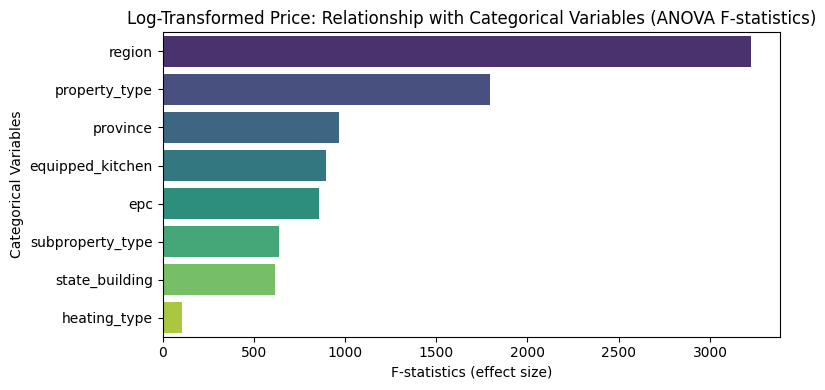

In [ ]:
# Visualization of the ANOVA results

import matplotlib.pyplot as pl

plt.figure(figsize=(8, 4))
sns.barplot(data=anova_df,x="F-statistic",y="Variable",palette="viridis")

plt.title("Log-Transformed Price: Relationship with Categorical Variables (ANOVA F-statistics)")
plt.xlabel("F-statistics (effect size)")
plt.ylabel("Categorical Variables")
plt.tight_layout()
plt.show()

In [ ]:
# Price vs binary variables - 

# Differently from other variables we do not treat None as a separate category as binaries in this data set do not have None. That is due to preliminary cleaning. 
# For this reason we use Point-biseral correlation, which is a special case of Pearson for binary vars
from scipy.stats import pointbiserialr

binary_vars = ["fl_floodzone", "fl_double_glazing", "fl_open_fire","fl_terrace", "fl_garden", "fl_swimming_pool", "fl_furnished"]

results = []

for var in binary_vars:
    corr, p_val = pointbiserialr(df[var], df['price_log'])
    results.append({'Variable': var, 'PointBiserial_r': corr, 'p-value': p_val})

pb_df = pd.DataFrame(results).sort_values(by='PointBiserial_r', ascending=False)
print(pb_df)

            Variable  PointBiserial_r        p-value
5   fl_swimming_pool         0.173760   0.000000e+00
3         fl_terrace         0.073522   5.334398e-91
4          fl_garden         0.064347   4.204211e-70
1  fl_double_glazing         0.026274   5.169462e-13
6       fl_furnished         0.001880   6.055190e-01
2       fl_open_fire        -0.014741   5.105627e-05
0       fl_floodzone        -0.090935  2.291938e-138


In [ ]:
# Inter-correlations matrix 
# price_log, zip_code, latitude, longitude excluded

import numpy as np
import pandas as pd
from scipy import stats
from math import sqrt

# Setting the variable types (epc and state_building are treated as nominal)
# Nominal categorical (multi-level)
nominal_vars = [
    "property_type", "subproperty_type", "region", "province", "locality",
    "equipped_kitchen", "heating_type",
    "epc",               # treated as nominal
    "state_building"     # treated as nominal
]

# Binary variables
binary_vars = [
    "fl_floodzone", "fl_double_glazing", "fl_open_fire",
    "fl_terrace", "fl_garden", "fl_swimming_pool", "fl_furnished"
]

# Continuous numeric
continuous_vars = ["total_area_sqm_log", "surface_land_sqm_log",
    "terrace_sqm_log", "garden_sqm_log", "primary_energy_consumption_sqm",
    "cadastral_income",
    # discrete numeric treated as continuous
    "nbr_bedrooms", "nbr_frontages", "construction_year"
]


# Effect sizes

def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2, p, _, _ = stats.chi2_contingency(table, correction=False)
    n = table.sum().sum()
    r, k = table.shape
    v = sqrt(chi2 / (n * (min(k - 1, r - 1))))
    return v, p

def correlation_ratio(categories, values):
    categories = categories.astype("category")
    groups = [values[categories == cat] for cat in categories.cat.categories]
    means = np.array([g.mean() for g in groups])
    counts = np.array([g.size for g in groups])
    total_mean = np.average(values)
    ss_between = np.sum(counts * (means - total_mean)**2)
    ss_total = np.sum((values - total_mean)**2)
    eta = sqrt(ss_between / ss_total) if ss_total != 0 else 0
    f_stat, p = stats.f_oneway(*groups)
    return eta, p


def mixed_associations(df, nominal, binary, continuous):
    cols = nominal + binary + continuous # Here we take only the columns stated above not directly from the df

    n = len(cols)

    assoc = pd.DataFrame(np.zeros((n, n)), index=cols, columns=cols)
    pvals = pd.DataFrame(np.ones((n, n)), index=cols, columns=cols)

    for i in range(n):
        for j in range(i, n):
            x, y = cols[i], cols[j]

            if x == y:
                assoc.loc[x,y] = 1.0
                pvals.loc[x,y] = 0.0
                continue

            # Continuous - Continuous
            if x in continuous and y in continuous:
                # Safely handling Nan without dropping the rows or replacing with 0
                subset = df[[x, y]].dropna()
                if subset.shape[0] < 2 or subset[x].nunique() <= 1 or subset[y].nunique() <= 1:
                    r, p = np.nan, np.nan
                else:
                    r, p = stats.pearsonr(subset[x], subset[y])
                assoc.loc[x,y], pvals.loc[x,y] = r, p

            # Continuous - Binary (point-biserial)
            elif (x in continuous and y in binary) or (x in binary and y in continuous):
                if x in binary:
                    bin_var, cont_var = df[x], df[y]
                else:
                    bin_var, cont_var = df[y], df[x]
                r, p = stats.pointbiserialr(bin_var, cont_var)
                assoc.loc[x,y], pvals.loc[x,y] = r, p

            # Binary - Binary (Phi coefficient)
            elif x in binary and y in binary:
                r, p = stats.pearsonr(df[x], df[y])
                assoc.loc[x,y], pvals.loc[x,y] = r, p

            # Continuous - Nominal (correlation ratio)
            elif (x in continuous and y in nominal) or (x in nominal and y in continuous):
                if x in continuous:
                    eta, p = correlation_ratio(df[y], df[x])
                else:
                    eta, p = correlation_ratio(df[x], df[y])
                assoc.loc[x,y], pvals.loc[x,y] = eta, p

            # Nominal - Nominal (Cramér’s V)
            elif x in nominal and y in nominal:
                v, p = cramers_v(df[x], df[y])
                assoc.loc[x,y], pvals.loc[x,y] = v, p

            # Binary - Nominal (Cramér’s V)
            elif (x in binary and y in nominal) or (x in nominal and y in binary):
                if x in binary:
                    v, p = cramers_v(df[x], df[y])
                else:
                    v, p = cramers_v(df[y], df[x])
                assoc.loc[x,y], pvals.loc[x,y] = v, p

            else:
                assoc.loc[x,y], pvals.loc[x,y] = np.nan, np.nan

            # mirror
            assoc.loc[y,x] = assoc.loc[x,y]
            pvals.loc[y,x] = pvals.loc[x,y]

    return assoc, pvals

#Running the analysis
assoc, pvals = mixed_associations(df, nominal_vars, binary_vars, continuous_vars)

threshold_p = 0.05
threshold_strength = 0.22 # rule of thumb for strength of relation : 0.3

strong_sig = assoc[(pvals < threshold_p) & (assoc.abs() >= threshold_strength)]

pairs = []
for i in assoc.index:
    for j in assoc.columns:
        if i < j and pvals.loc[i,j] < threshold_p and abs(assoc.loc[i,j]) >= threshold_strength:
            pairs.append((i, j, assoc.loc[i,j], pvals.loc[i,j]))

strong_pairs_df = pd.DataFrame(pairs, columns=["var1", "var2", "association", "pvalue"])

print("=== Full Association Matrix ===")
display(assoc.round(2)) 

=== Full Association Matrix ===


,property_type,subproperty_type,region,province,locality,equipped_kitchen,heating_type,epc,state_building,fl_floodzone,...,fl_furnished,total_area_sqm_log,surface_land_sqm_log,terrace_sqm_log,garden_sqm_log,primary_energy_consumption_sqm,cadastral_income,nbr_bedrooms,nbr_frontages,construction_year
property_type,1.00,1.00,0.22,0.27,0.32,0.14,0.26,0.39,0.26,0.01,...,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.54,0.00,0.00
subproperty_type,1.00,1.00,0.20,0.12,0.10,0.08,0.12,0.25,0.13,0.06,...,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.00
region,0.22,0.20,1.00,1.00,1.00,0.23,0.18,0.16,0.11,0.33,...,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00
province,0.27,0.12,1.00,1.00,1.00,0.14,0.12,0.15,0.09,0.35,...,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.00
locality,0.32,0.10,1.00,1.00,1.00,0.15,0.14,0.17,0.11,0.36,...,0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00
equipped_kitchen,0.14,0.08,0.23,0.14,0.15,1.00,0.14,0.16,0.19,0.11,...,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00
heating_type,0.26,0.12,0.18,0.12,0.14,0.14,1.00,0.23,0.12,0.08,...,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00
epc,0.39,0.25,0.16,0.15,0.17,0.16,0.23,1.00,0.30,0.05,...,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00
state_building,0.26,0.13,0.11,0.09,0.11,0.19,0.12,0.30,1.00,0.11,...,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.00
fl_floodzone,0.01,0.06,0.33,0.35,0.36,0.11,0.08,0.05,0.11,1.00,...,-0.03,NaN,NaN,NaN,NaN,NaN,NaN,-0.02,NaN,NaN


In [ ]:
# Inter-correlations matrix - single out strong and significant correlations
pairs = []
for i in assoc.index:
    for j in assoc.columns:
        if i < j and pvals.loc[i,j] < threshold_p and abs(assoc.loc[i,j]) >= threshold_strength:
            pairs.append((i, j, assoc.loc[i,j], pvals.loc[i,j]))

strong_pairs_df = pd.DataFrame(pairs, columns=["var1", "var2", "association", "pvalue"])
print("=== Significant & Strong Associations (pairwise table) ===")
display(strong_pairs_df.sort_values(by="association", key=lambda x: x.abs(), ascending=False))

=== Significant & Strong Associations (pairwise table) ===


,var1,var2,association,pvalue
4,province,region,1.000000,0.0
6,locality,region,1.000000,0.0
7,locality,province,1.000000,0.0
0,property_type,subproperty_type,1.000000,0.0
31,nbr_bedrooms,total_area_sqm_log,0.745861,0.0
30,nbr_bedrooms,subproperty_type,0.601790,0.0
29,nbr_bedrooms,property_type,0.537008,0.0
33,nbr_frontages,surface_land_sqm_log,0.440129,0.0
13,epc,property_type,0.394034,0.0
19,fl_floodzone,locality,0.363847,0.0


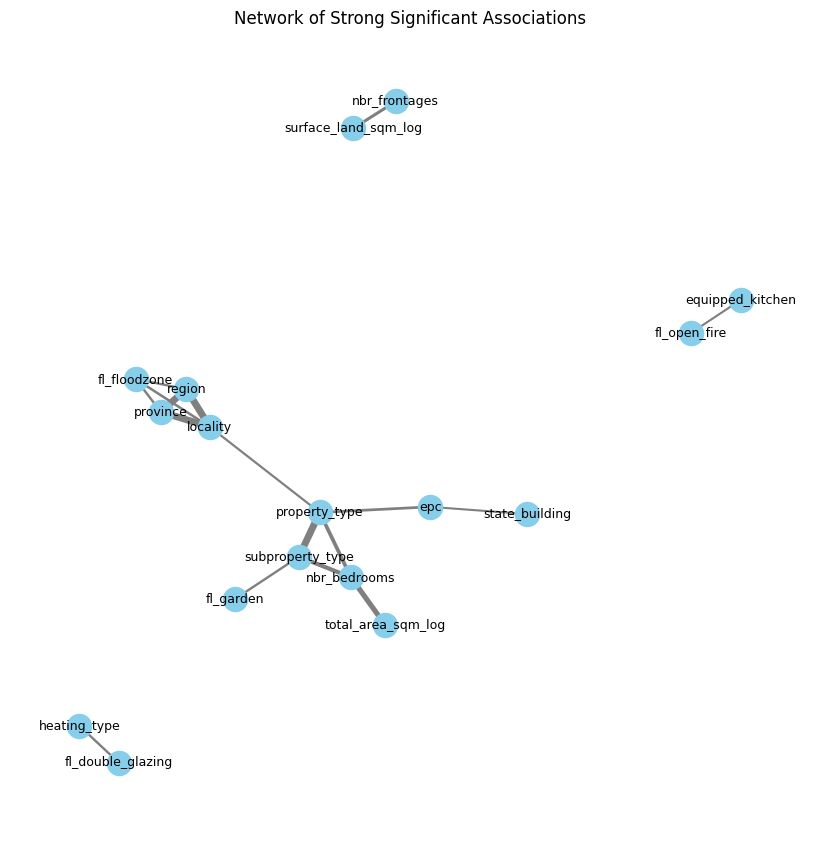

In [ ]:
# Inter-correlations matrix - visualizaiton
import networkx as nx

# Build graph
G = nx.Graph()
for i in assoc.index:
    for j in assoc.columns:
        if i < j and pvals.loc[i,j] < 0.05 and abs(assoc.loc[i,j]) >= 0.3:
            G.add_edge(i, j, weight=assoc.loc[i,j])

# Draw
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=0.5, iterations=110, seed=52)
edges = G.edges(data=True)
weights = [abs(d['weight'])*5 for (u,v,d) in edges]  # scale width
nx.draw(G, pos, with_labels=True, font_size=9, width=weights, node_color='skyblue', edge_color='grey')
plt.title("Network of Strong Significant Associations")
plt.show()

In [ ]:
# Interaction effects


# total areaX subproperty_type
# provinceX epc
# regionXsub_type
#